# Corpo isolado uniformemente magnetizado

Este código está escrito em linguagem [Python](https://www.python.org/) e utiliza o subpacote [gravmag](http://www.fatiando.org/api/gravmag.html#module-fatiando.gravmag) do [Fatiando a Terra](http://www.fatiando.org/index.html).

In [1]:
from fatiando import gridder, utils, mesher
from fatiando.gravmag import prism, harvester, polyprism
from fatiando.mesher import Prism, PrismMesh, vremove
from fatiando.vis import mpl, myv

/home/vanderlei/anaconda2/envs/SEGEO2017/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
/home/vanderlei/anaconda2/envs/SEGEO2017/lib/python2.7/site-packages/fatiando/vis/myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


In [2]:
import numpy as np

In [3]:
bounds = [0, 5000, 0, 5000, 0, 3000]
area = bounds[:4]

In [16]:
N = 30
t = np.linspace(0., 2*np.pi, N)
a = 2000
b = 1200
x0 = 2300.
y0 = 2600.
theta = np.deg2rad(35.)

In [25]:
vertices_x = a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta) + x0 + \
             0.3*a*np.random.rand(N)*np.cos(t)*np.cos(theta)
vertices_y = a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta) + y0 + \
             0.3*b*np.random.rand(N)*np.cos(t)*np.cos(theta)
vertices = np.vstack([vertices_x, vertices_y]).T
model = [mesher.PolygonalPrism(vertices, 1000, 2500, {'density': 500})]

In [26]:
# show it
myv.figure()
myv.polyprisms(model, 'density')
myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds],
         fmt='%.1f', nlabels=6)
myv.wall_bottom(bounds)
myv.wall_north(bounds)
myv.show()

In [28]:
# and use it to generate some tensor data
shape = (51, 51)
area = bounds[0:4]
noise = 2
x, y, z = gridder.regular(area, shape, z=-150)
gyy = utils.contaminate(polyprism.gyy(x, y, z, model), noise)
gyz = utils.contaminate(polyprism.gyz(x, y, z, model), noise)
gzz = utils.contaminate(polyprism.gzz(x, y, z, model), noise)

In [29]:
# Set up the inversion:
# Create a prism mesh
mesh = PrismMesh(bounds, (15, 50, 50))
# Wrap the data so that harvester can use it
data = [harvester.Gyy(x, y, z, gyy),
        harvester.Gyz(x, y, z, gyz),
        harvester.Gzz(x, y, z, gzz)]

In [30]:
# and the seeds
seeds = harvester.sow([(x0, y0, 1500, {'density': 500})], mesh)

In [31]:
# Run the inversion and collect the results
estimate, predicted = harvester.harvest(data, seeds, mesh,
                                        compactness=1., threshold=0.0001)

In [32]:
# Insert the estimated density values into the mesh
mesh.addprop('density', estimate['density'])
# and get only the prisms corresponding to our estimate
density_model = vremove(0, 'density', mesh)
print "Accretions: %d" % (len(density_model) - len(seeds))

Accretions: 6531


In [33]:
# Get the predicted data from the data modules
tensor = (gyy, gyz, gzz)

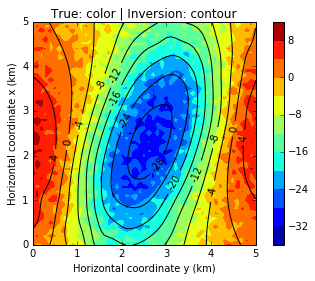

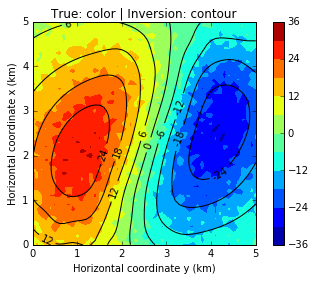

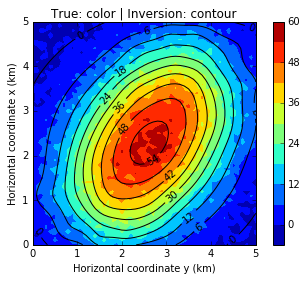

In [38]:
# plot it
for true, pred in zip(tensor, predicted):
    mpl.figure()
    mpl.title("True: color | Inversion: contour")
    mpl.axis('scaled')
    levels = mpl.contourf(y * 0.001, x * 0.001, true, shape, 12)
    mpl.colorbar()
    mpl.contour(y * 0.001, x * 0.001, pred, shape, levels, color='k')
    mpl.xlabel('Horizontal coordinate y (km)')
    mpl.ylabel('Horizontal coordinate x (km)')
mpl.show()

In [42]:
# Plot the inversion result
myv.figure()
myv.polyprisms(model, 'density', style='wireframe')
myv.prisms(density_model, 'density', vmin=0)
myv.axes(myv.outline(bounds), ranges=[i * 0.001 for i in bounds], fmt='%.1f',
         nlabels=6)
myv.wall_bottom(bounds)
myv.wall_north(bounds)
myv.show()

AttributeError: 'Prism' object has no attribute 'x'